In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import folium

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from neupy import algorithms, estimators, environment, layers, plots, init
from xgboost import XGBClassifier

from RBFN import RBFN
from ensemble import AveragedNetwork

sns.set(style="whitegrid")

### Load & Merge Data [Note: raw datafiles are stored in /Data]

In [2]:
properties = pd.read_csv('Data/properties_2016.csv', header=0, encoding='utf-8')
train = pd.read_csv('Data/train_2016_v2.csv', parse_dates=["transactiondate"], header=0, encoding='utf-8')

merged_df = pd.merge(train,properties,on="parcelid",how="left")

print("Shape Of Dataset: ", merged_df.shape)

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape Of Dataset:  (90275, 60)


### Save Merged Data

In [3]:
merged_df.to_csv("Data/merged_2016.csv", index=False)

# Data Exploration

### Load Data

In [2]:
merged_df = pd.read_csv("Data/merged_2016.csv")

### Describe Data

In [3]:
merged_df.describe().to_csv("data_desc.csv")
merged_df.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,9.027500e+04,90275.000000,28781.000000,261.000000,43.000000,90275.000000,90275.000000,16.0,57364.000000,89093.000000,...,95.000000,89519.000000,20570.000000,8.989500e+04,9.027400e+04,90275.0,9.027400e+04,90269.000000,1783.000000,8.967000e+04
mean,1.298466e+07,0.011457,1.816372,7.229885,713.581395,2.279474,3.031869,4.0,5.565407,2.309216,...,311.694737,1968.532870,1.440739,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,13.402692,6.049151e+13
std,2.504510e+06,0.161079,2.974168,2.716196,437.434198,1.004271,1.156436,0.0,1.900602,0.976172,...,346.354850,23.763475,0.544498,2.091299e+05,5.548844e+05,0.0,4.004955e+05,6838.876956,2.715966,2.046605e+11
min,1.071174e+07,-4.605000,1.000000,2.000000,100.000000,0.000000,0.000000,4.0,1.000000,1.000000,...,18.000000,1885.000000,1.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.000000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,7.000000,407.500000,2.000000,2.000000,4.0,4.000000,2.000000,...,100.000000,1953.000000,1.000000,8.124500e+04,1.990232e+05,2015.0,8.222800e+04,2872.830000,13.000000,6.037320e+13
50%,1.254734e+07,0.006000,1.000000,7.000000,616.000000,2.000000,3.000000,4.0,7.000000,2.000000,...,159.000000,1970.000000,1.000000,1.320000e+05,3.428720e+05,2015.0,1.929700e+05,4542.750000,14.000000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,7.000000,872.000000,3.000000,4.000000,4.0,7.000000,3.000000,...,361.000000,1987.000000,2.000000,2.105345e+05,5.405890e+05,2015.0,3.454195e+05,6901.090000,15.000000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,21.000000,1555.000000,20.000000,16.000000,4.0,12.000000,20.000000,...,1366.000000,2015.000000,4.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,99.000000,6.111009e+13


### Display Features Data Type

In [4]:
pd.options.display.max_rows = 65

dtype_df = merged_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,object
3,airconditioningtypeid,float64
4,architecturalstyletypeid,float64
5,basementsqft,float64
6,bathroomcnt,float64
7,bedroomcnt,float64
8,buildingclasstypeid,float64
9,buildingqualitytypeid,float64


### Show Frst Few Rows of Data

In [5]:
merged_df.head(3).transpose()

,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01,2016-01-01,2016-01-01
airconditioningtypeid,1,NaN,1
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2,3.5,3
bedroomcnt,3,4,2
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4


### Geoplot properties location

In [6]:
from sklearn.cluster import MiniBatchKMeans

geographical_df = merged_df.loc[:, ('latitude', 'longitude', 'logerror')]
geographical_df['longitude'] = geographical_df['longitude'] / 1000000
geographical_df['latitude'] = geographical_df['latitude'] / 1000000
geographical_df = geographical_df.dropna(subset=['latitude','longitude'], axis=0)

kmeans = MiniBatchKMeans(n_clusters=120, batch_size=1000).fit(geographical_df[['latitude','longitude']])
geographical_df.loc[:, 'label'] = kmeans.labels_

geo_map = folium.Map(location=[geographical_df['latitude'].mean(), geographical_df['longitude'].mean()], zoom_start=9)

for label in kmeans.cluster_centers_:
    location = [label[0], label[1]]
    folium.Marker(location=location).add_to(geo_map)

geo_map

### Plot the target class (logerror of Zillow)

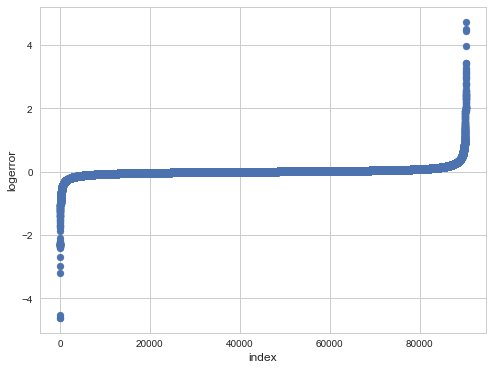

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(range(merged_df.shape[0]), np.sort(merged_df['logerror'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

This looks nice with some outliers at both the ends!

Let us remove the outliers and then do a histogram plot on the same.

In [8]:
merged_df = merged_df[merged_df['logerror'] < merged_df['logerror'].quantile(.99)]
merged_df = merged_df[merged_df['logerror'] > merged_df['logerror'].quantile(.01)]

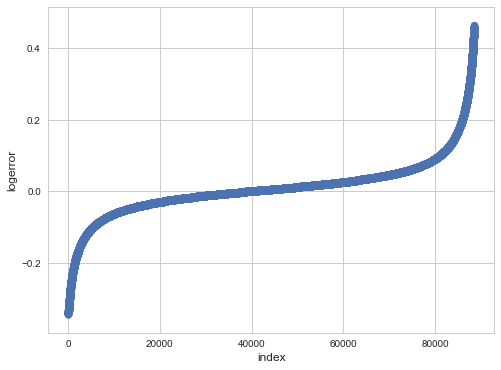

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(range(merged_df.shape[0]), np.sort(merged_df['logerror']))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

### Plot Histogram of Target Class (logerror)

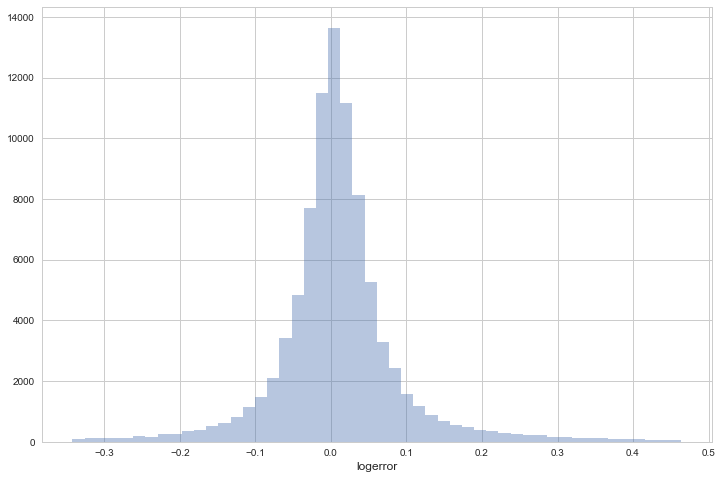

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(merged_df['logerror'], bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

### Missing values

We have seen many missing values in the data peeking. How many missing values are there for each feature? In fact, some features are missing nearly completely. So, we probably have to work more with the others.

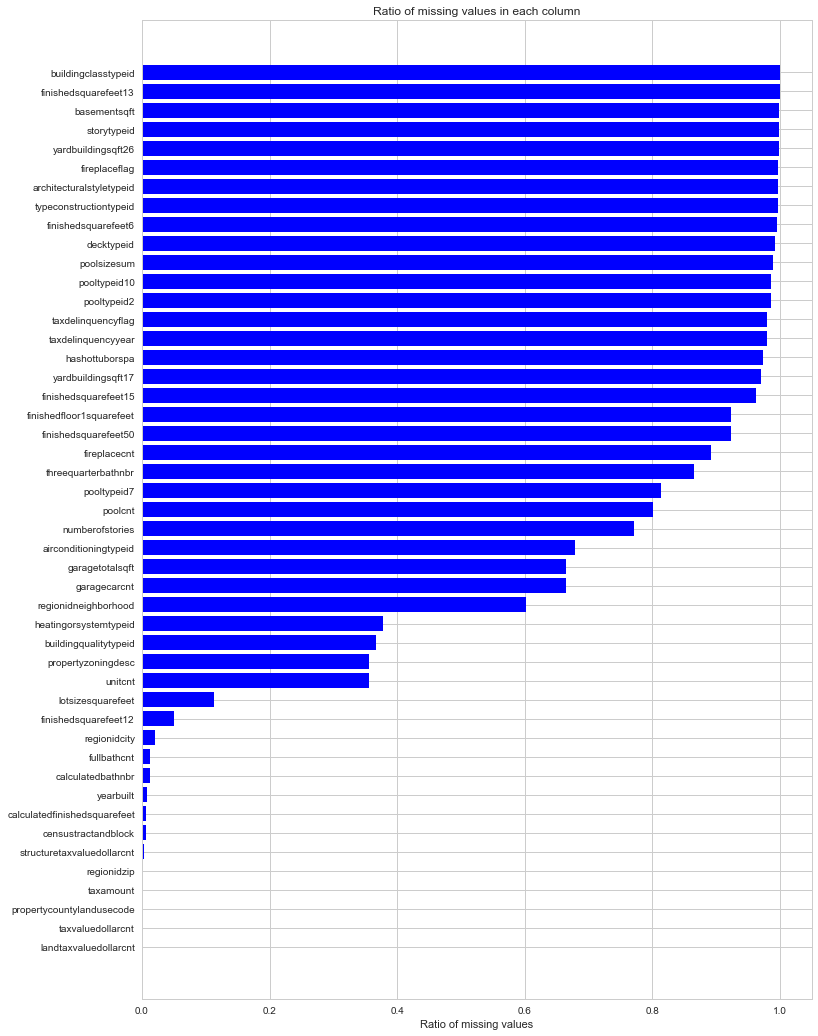

In [11]:
missing_values_df = merged_df.isnull().sum(axis=0).reset_index()
missing_values_df.columns = ['column_name', 'missing_count']
missing_values_df['missing_ratio'] = missing_values_df['missing_count'] / merged_df.shape[0]

missing_values_df = missing_values_df[missing_values_df['missing_count'] > 0]
missing_values_df = missing_values_df.sort_values(by='missing_count')

ind = np.arange(missing_values_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_values_df['missing_ratio'], color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values_df['column_name'], rotation='horizontal')
ax.set_xlabel("Ratio of missing values")
ax.set_title("Ratio of missing values in each column")
plt.show()

### Remove features with high degree of missing values

In [12]:
removed_columns_df = missing_values_df[missing_values_df['missing_ratio'] > 0.6]
removed_columns = removed_columns_df[removed_columns_df.columns[0]].tolist()

good_features_df = merged_df.drop(removed_columns, axis=1)

print("Removed Features")
removed_columns

Removed Features


['regionidneighborhood',
 'garagecarcnt',
 'garagetotalsqft',
 'airconditioningtypeid',
 'numberofstories',
 'poolcnt',
 'pooltypeid7',
 'threequarterbathnbr',
 'fireplacecnt',
 'finishedsquarefeet50',
 'finishedfloor1squarefeet',
 'finishedsquarefeet15',
 'yardbuildingsqft17',
 'hashottuborspa',
 'taxdelinquencyyear',
 'taxdelinquencyflag',
 'pooltypeid2',
 'pooltypeid10',
 'poolsizesum',
 'decktypeid',
 'finishedsquarefeet6',
 'typeconstructiontypeid',
 'architecturalstyletypeid',
 'fireplaceflag',
 'yardbuildingsqft26',
 'storytypeid',
 'basementsqft',
 'finishedsquarefeet13',
 'buildingclasstypeid']

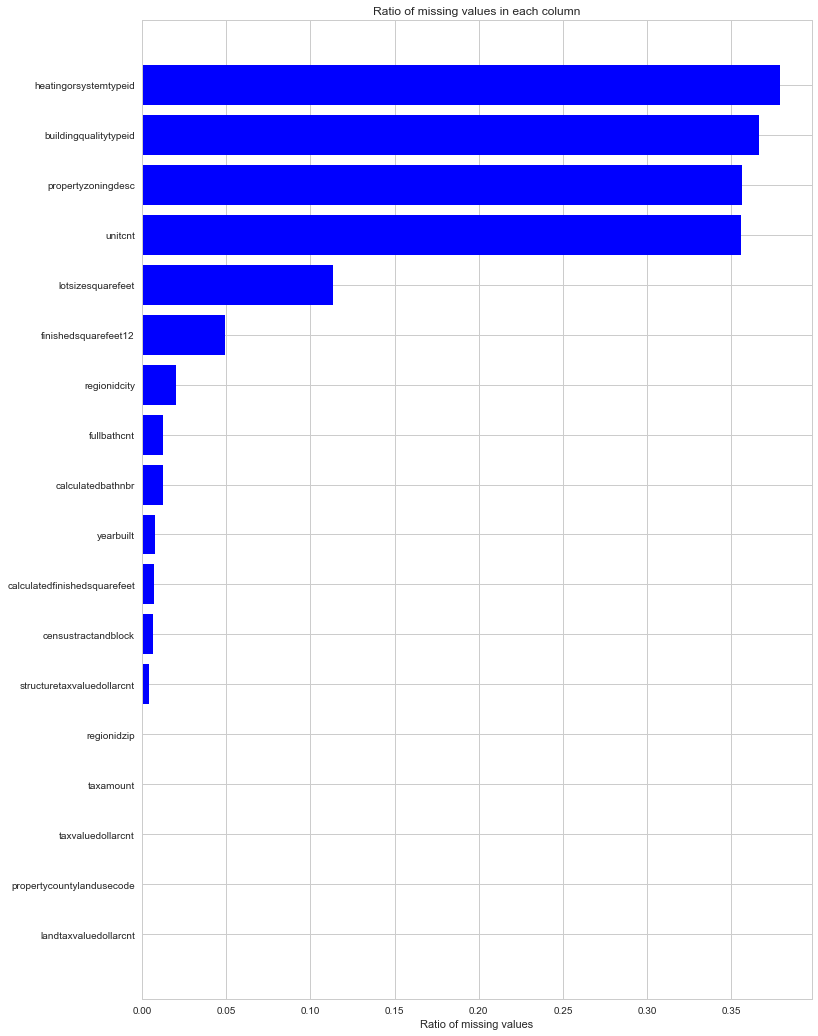

In [13]:
missing_values_df = good_features_df.isnull().sum(axis=0).reset_index()
missing_values_df.columns = ['column_name', 'missing_count']
missing_values_df['missing_ratio'] = missing_values_df['missing_count'] / merged_df.shape[0]

missing_values_df = missing_values_df[missing_values_df['missing_count'] > 0]
missing_values_df = missing_values_df.sort_values(by='missing_count')

ind = np.arange(missing_values_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_values_df['missing_ratio'], color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_values_df['column_name'], rotation='horizontal')
ax.set_xlabel("Ratio of missing values")
ax.set_title("Ratio of missing values in each column")
plt.show()

### Inspect manually -with data dictionary and domain knowledge - and confirm one by one if variable is to be discarded for high degree of missing values or they can be salvaged

In [14]:
#taxdelinquencyflag may be important, will fill it with "False" if it is not true
#'garage' and 'garage' features may be important for US and they are 0 if data is not filled in

merged_df['taxdelinquencyflag'] = merged_df['taxdelinquencyflag'].apply(lambda x: 1 if x == "Y" else 0)
merged_df['garagecarcnt'] = merged_df['garagecarcnt'].fillna(0)  #important to US people
merged_df['garagetotalsqft'] = merged_df['garagetotalsqft'].fillna(0) #important to US people

removed_columns = ['regionidneighborhood',
 'airconditioningtypeid',
 'numberofstories',
 'poolcnt',
 'pooltypeid7',
 'threequarterbathnbr',
 'fireplacecnt',
 'finishedsquarefeet50',
 'finishedfloor1squarefeet',
 'finishedsquarefeet15',
 'yardbuildingsqft17',
 'hashottuborspa',
 'taxdelinquencyyear',
 'pooltypeid2',
 'pooltypeid10',
 'poolsizesum',
 'decktypeid',
 'finishedsquarefeet6',
 'typeconstructiontypeid',
 'architecturalstyletypeid',
 'fireplaceflag',
 'yardbuildingsqft26',
 'storytypeid',
 'basementsqft',
 'finishedsquarefeet13',
 'buildingclasstypeid'
    ]

good_features_df = merged_df.drop(removed_columns, axis=1)

print("Removed features due to high degree of missing data and after manual inspection")
removed_columns

Removed features due to high degree of missing data and after manual inspection


['regionidneighborhood',
 'airconditioningtypeid',
 'numberofstories',
 'poolcnt',
 'pooltypeid7',
 'threequarterbathnbr',
 'fireplacecnt',
 'finishedsquarefeet50',
 'finishedfloor1squarefeet',
 'finishedsquarefeet15',
 'yardbuildingsqft17',
 'hashottuborspa',
 'taxdelinquencyyear',
 'pooltypeid2',
 'pooltypeid10',
 'poolsizesum',
 'decktypeid',
 'finishedsquarefeet6',
 'typeconstructiontypeid',
 'architecturalstyletypeid',
 'fireplaceflag',
 'yardbuildingsqft26',
 'storytypeid',
 'basementsqft',
 'finishedsquarefeet13',
 'buildingclasstypeid']

# Compute the correlation matrix

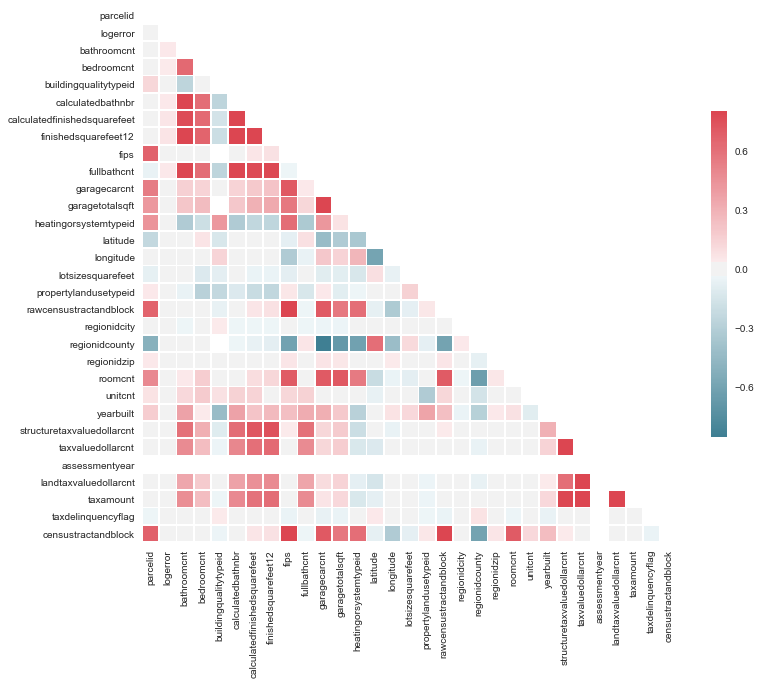

In [15]:
corr = good_features_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

### Filter out Correlated Features for inspection (Not needed anymore since we remove manually)

In [16]:
def remove_correlation(input_dataset, threshold):
    dataset = input_dataset.copy(deep=True)
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                colname_j = corr_matrix.columns[j] # getting the name of the other column
                col_corr.add(colname)
                if colname in dataset.columns:
                    print("Remove '{}' due to it's similarity to '{}'".format(colname, colname_j))
                    del dataset[colname] # deleting the column from the dataset

    return dataset, col_corr

### Inspect correlated Features manually and remove thems

In [17]:
# Remove 'num_bathroom' instead of 'calculatedbathnbr' as Zillow clarified that they used 'calculatedbathnbr' for their Zillow Est.
# Remove 'finishedsquarefeet12' due to it's similarity to 'calculatedfinishedsquarefeet' This is ok!! area_live_finished which is calculatedfinishedsquarefeet has more complete data!
# Remove 'fullbathcnt' due to it's similarity to 'bathroomcnt' --> Looks ok, the bathroomcnt have more data
# Remove 'rawcensustractandblock' due to it's similarity to 'fips'
# Remove 'landtaxvaluedollarcnt' due to it's similarity to 'taxvaluedollarcnt' --> Looks ok, Taxvaluedollarcnt has more infomration
# Remove 'taxamount' due to it's similarity to 'taxvaluedollarcnt'
# Remove 'censustractandblock' due to it's similarity to 'fips' 

removed_columns =[
    'bathroomcnt',
    'censustractandblock',
    'finishedsquarefeet12',
    'fullbathcnt',
    'landtaxvaluedollarcnt',
    'rawcensustractandblock',
    'taxamount'
]

good_features_df = good_features_df.drop(removed_columns, axis=1)

### Further Feature Inspection and Feature Engineering

In [18]:
removed_columns = [
    "parcelid", #Removed Unique Ident
    "transactiondate", # Not vital for current problem
    "latitude", # regionid more than sufficient for segmentation
    "longitude", # regionid more than sufficient for segmentation
    "propertycountylandusecode", #1 hot encoded land use have more detailed information
    "propertyzoningdesc",  #1 hot encoded land use have more detailed information
    "fips", #the 1-hot encoded postal code has better information
    "assessmentyear", # same information  #### LOOK AT it after new plots!
]

good_features_df = good_features_df.drop(removed_columns, axis=1)

### Impute several missing value (N/A) with zero (0) or special value if applicable

In [19]:
good_features_df['heatingorsystemtypeid'] = good_features_df['heatingorsystemtypeid'].fillna(13)  #Fill as 13 which is "None" category in data_dictu

### Impute the rest of missing value (N/A) with Mean value

In [20]:
good_features_df = good_features_df.fillna(good_features_df.mean())

In [21]:
def train_validate_test_split(features, target, validate_size, test_size):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = (validate_size + test_size))
    x_validate, x_test, y_validate, y_test = train_test_split(x_test, y_test, test_size = test_size / (validate_size + test_size))
    return x_train, x_validate, x_test, y_train, y_validate, y_test

In [22]:
def dataframe_split(dataframe, target_column, as_matrix=True):
    target = dataframe[target_column]
    features = dataframe.loc[:, dataframe.columns != target_column]
    if as_matrix:
        target = target.as_matrix()
        features = features.as_matrix()
    return features, target

# Feature Selection with XGBoost Feature Importance Scores

In [ ]:
environment.reproducible()

target_column = 'logerror'
xgb_df = good_features_df.drop(["parcelid", "transactiondate"], axis=1)

features, target = dataframe_split(xgb_df, target_column)

x_train, x_test, y_train, y_test = train_test_split(
    features,
    target.reshape((-1, 1)),
    test_size=0.3,
)

In [ ]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train.ravel())

# feature importance
xgb_model.feature_importances_

### One-Hot Encoding for Zoning Data

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

zoning_df = good_features_df.loc(:, ['regionidzip', 'propertylandusetypeid'])
other_df = good_features_df.drop(zoning_df.columns.tolist(), axis=1)

zoning_df['regionidzip'] = zoning_df['regionidzip'].astype('category')
zoning_df['propertylandusetypeid'] = zoning_df['propertylandusetypeid'].astype('category')

zoning_df = pd.get_dummies(zoning_df)

good_features_df = pd.concat([other_df, zoning_df], axis=1)

good_features_df.head(3)

# Create final dataset

In [23]:
environment.reproducible()

target_column = "logerror"

dropped_columns = [ #all dropping done at feature engineering section, 
    "regionidzip",   #Regionidzip should be 1 hot encoded!!
    "propertylandusetypeid" # propertylandusetypeid should be 1 hot encoded!
]

final_df = good_features_df.drop(dropped_columns, axis=1) #all dropping done at feature engineering section, 
features, target = dataframe_split(final_df, target_column)

x_train, x_validate, x_test, y_train, y_validate, y_test = train_validate_test_split(
    preprocessing.minmax_scale(features),
    preprocessing.minmax_scale(target.reshape((-1, 1))),
    validate_size=0.15, 
    test_size=0.15,
)

num_features = x_train.shape[1]
num_target = y_train.shape[1]

### Test Neupy GRNN on our dataset

In [24]:
grnn_model = algorithms.GRNN(std=0.7, verbose=True)
grnn_model.train(x_train, y_train)

with open('grnn.pickle', 'wb') as f:
    pickle.dump(grnn_model, f)


Main information

[ALGORITHM] GRNN

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] std = 0.7



### Evaluate the model

In [25]:
y_predicted = grnn_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10432285860681685
Mean Absolute Error (0=Best, 1=Worst): 0.06680479965023232
Median Absolute Error (0=Best, 1=Worst): 0.04035523525150686


### Residual Plot

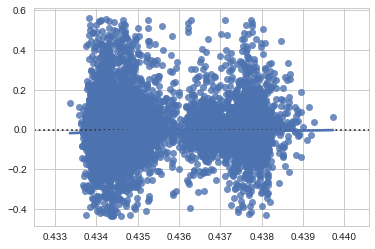

In [26]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

There is no pattern on the residual plot, that means our model decently predict the target class, since,

1. they’re pretty symmetrically distributed, tending to cluster towards the middle of the plot
2. they’re clustered around the lower single digits of the y-axis (e.g., 0.5 or 1.5, not 30 or 150)
3. in general there aren’t clear patterns

### Grid search for std parameters

In [ ]:
params = np.linspace(0.1, 0.9, 9)

best_rmse = 1
best_std = 0

for std in params:
    grnn = algorithms.GRNN(std=std, verbose=True)
    grnn.train(x_train, y_train)
    
    y_predicted = grnn.predict(x_test)
    rmse = estimators.rmse(y_predicted, y_test)
    print("RMSE {} for std {}".format(rmse, std))
    if rmse < best_rmse:
        best_rmse = rmse
        best_std = std
        
        with open('grnn.pickle', 'wb') as f:
            pickle.dump(grnn, f)
    else:
        print("Exit Grid Search")
        break

print("Best std = {} with RMSE = {}".format(best_std, best_rmse))

# Load saved GRNN model

In [27]:
with open('grnn.pickle', 'rb') as f:
    grnn_model = pickle.load(f)
    
    y_predicted = grnn_model.predict(x_test)

In [28]:
df_test = pd.DataFrame(np.concatenate((y_test, y_predicted), axis=1), columns={'actual_logerror', 'predicted_logerror'})
df_test.to_csv('grnn_prediction_result_best.csv', sep=',', encoding='utf-8', index=False)

# Radial Basis Function Network

In [29]:
num_features = x_train.shape[1]

rbfn_model = RBFN(input_shape = num_features, hidden_shape = num_features)
rbfn_model.train(x_train,y_train)

with open('rbfn.pickle', 'wb') as f:
    pickle.dump(rbfn_model, f)

### Evaluate the model

In [30]:
y_predicted = rbfn_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.11437328776671218
Mean Absolute Error (0=Best, 1=Worst): 0.07464113975899288
Median Absolute Error (0=Best, 1=Worst): 0.04613685348594465


### Residual Plot

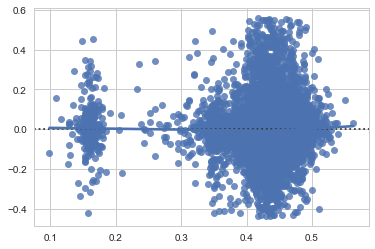

In [31]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

# Conjugate Gradient Neural Network


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 3.41 seconds

Start training

[TRAINING DATA] shapes: (61931, 16)
[TEST DATA] shapes: (13271, 16)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.010702 |    0.010632 |       1 sec |
|          25 |    0.010647 |    0.010576 |       2 sec |
|          50 |     0.01064 |    0.010572 |       2 sec |
|          75 |     0.01064

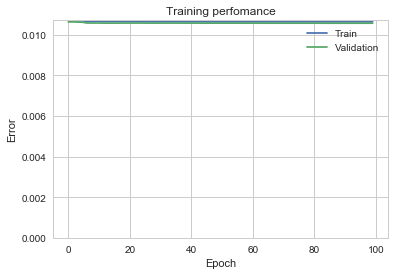

In [32]:
cgnet_model = algorithms.ConjugateGradient(
    connection=[
        layers.Input(num_features),
        layers.Sigmoid(50),
        layers.Sigmoid(num_target),
    ],
    search_method='golden',
    show_epoch=25,
    verbose=True,
    addons=[algorithms.LinearSearch],
)

cgnet_model.train(x_train, y_train, x_validate, y_validate, epochs=100)

plots.error_plot(cgnet_model)

with open('cgnet.pickle', 'wb') as f:
    pickle.dump(cgnet_model, f)

In [33]:
y_predicted = cgnet_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10402019048820435
Mean Absolute Error (0=Best, 1=Worst): 0.06658754483325165
Median Absolute Error (0=Best, 1=Worst): 0.0398144020032582


### Residual Plot

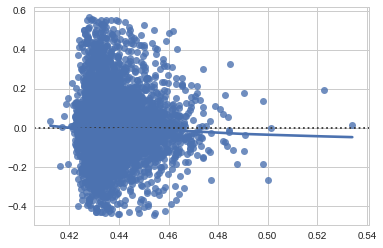

In [34]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

# Gradient Descent Network

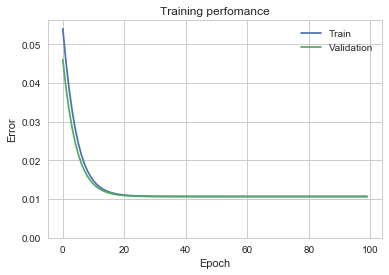

In [35]:
class Exponential(init.Initializer):
    def __init__(self, scale=0.01):
        self.scale = scale

    def sample(self, shape):
        return np.random.exponential(self.scale, size=shape)
    
gdnet_model = algorithms.GradientDescent(
    [
        layers.Input(num_features),
        layers.Sigmoid(num_features * 2, weight=Exponential(scale=0.02)),
        layers.Sigmoid(num_target, weight=Exponential(scale=0.05)),
    ]
)

gdnet_model.train(x_train, y_train, x_validate, y_validate, epochs=100)

plots.error_plot(gdnet_model)

with open('gdnet.pickle', 'wb') as f:
    pickle.dump(gdnet_model, f)

In [36]:
y_predicted = gdnet_model.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.1043330129991362
Mean Absolute Error (0=Best, 1=Worst): 0.06684160877681126
Median Absolute Error (0=Best, 1=Worst): 0.04035622031791797


### Residual Plot

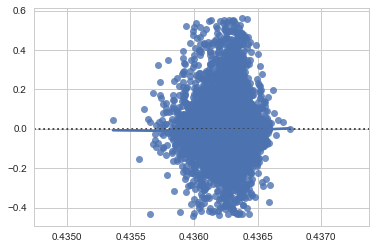

In [37]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)

# Ensembled Model using average method

In [38]:
f = open('grnn.pickle', 'rb')
grnn_model = pickle.load(f)

f = open('rbfn.pickle', 'rb')
rbfn_model = pickle.load(f)

f = open('cgnet.pickle', 'rb')
cgnet_model = pickle.load(f)

f = open('gdnet.pickle', 'rb')
gdnet_model = pickle.load(f)


Main information

[ALGORITHM] ConjugateGradient

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 25
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] error = mse
[OPTION] addons = ['LinearSearch']
[OPTION] update_function = fletcher_reeves
[OPTION] maxiter = 10
[OPTION] search_method = golden
[OPTION] tol = 0.1

[THEANO] Initializing Theano variables and functions.
[THEANO] Initialization finished successfully. It took 0.31 seconds


In [39]:
ensemble = AveragedNetwork([grnn_model, cgnet_model, gdnet_model])

y_ensemble_predicted = ensemble.predict(x_test)

print("Root Mean Square Error (0=Best, 1=Worst): {}".format(estimators.rmse(y_test, y_ensemble_predicted)))
print("Mean Absolute Error (0=Best, 1=Worst): {}".format(mean_absolute_error(y_test, y_ensemble_predicted)))
print("Median Absolute Error (0=Best, 1=Worst): {}".format(median_absolute_error(y_test, y_ensemble_predicted)))

Root Mean Square Error (0=Best, 1=Worst): 0.10416528728310334
Mean Absolute Error (0=Best, 1=Worst): 0.06667664610388196
Median Absolute Error (0=Best, 1=Worst): 0.039860753514768865


In [40]:
with open('ensembled_network.pickle', 'wb') as f:
    pickle.dump(ensemble, f)

### Residual Plot

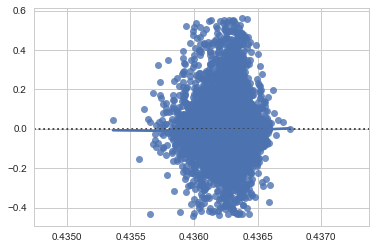

In [41]:
sns.residplot(y_predicted.ravel(), y_test.ravel(), lowess=True)